In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Date, Text
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base() 
from flask import Flask, jsonify

In [5]:
database_path = "hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
# engine = create_engine(f"sqlite:///Advanced-Data-Storage-and-Retrieval/hawaii.sqlite")
conn = engine.connect()
Base.metadata.create_all(conn)
session = Session(bind=engine)

Now, we will reflect that database (set up the metadata of what tables we have).

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

Inspect Tables
We note that we have two tables, measurement and station. We will save classes of these to be able to reference the tables. Presumably, these correspond to actual weather measurements and information about specific stations.

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#inspect measurement schema
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect stations schema
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

#Trip Dates¶
We need to pick trip dates. We will use a January 2019 trip time, assuming that crowds will dip after the holiday season. So, we will go on June 4th, 2019 and return on June 20th, 2019.

We will save these as date objects.

In [12]:
#save start date and end date
start_date = dt.date(2019, 6, 4)
end_date = dt.date(2019, 6, 20)

# Exploratory Climate Analysis
We will do some basic exploratory analysis of the data first.

Precipitation Analysis First, we will look at precipitation data for the last year.

As we don't know how dates are formatted, we will inspect them first.

In [13]:
#inspect how the dates are formatted
sample_date = session.query(Measurement.date).limit(5).all()
for result in sample_date:
    print(sample_date)

[('2010-01-01',), ('2010-01-02',), ('2010-01-03',), ('2010-01-04',), ('2010-01-06',)]
[('2010-01-01',), ('2010-01-02',), ('2010-01-03',), ('2010-01-04',), ('2010-01-06',)]
[('2010-01-01',), ('2010-01-02',), ('2010-01-03',), ('2010-01-04',), ('2010-01-06',)]
[('2010-01-01',), ('2010-01-02',), ('2010-01-03',), ('2010-01-04',), ('2010-01-06',)]
[('2010-01-01',), ('2010-01-02',), ('2010-01-03',), ('2010-01-04',), ('2010-01-06',)]


In [14]:
#dates are formatted as YYYY-MM-DD
#we will get the maximum date after formatting the dates appropriately
#first is used as there are multiple measurements on the same day
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [15]:
#access all precipitation data from the last year (as the end of the data is our endpoint, we only need one comparison)
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [16]:
#load as a dataframe
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)

#look at dataframe
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [17]:
#sort dataframe
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


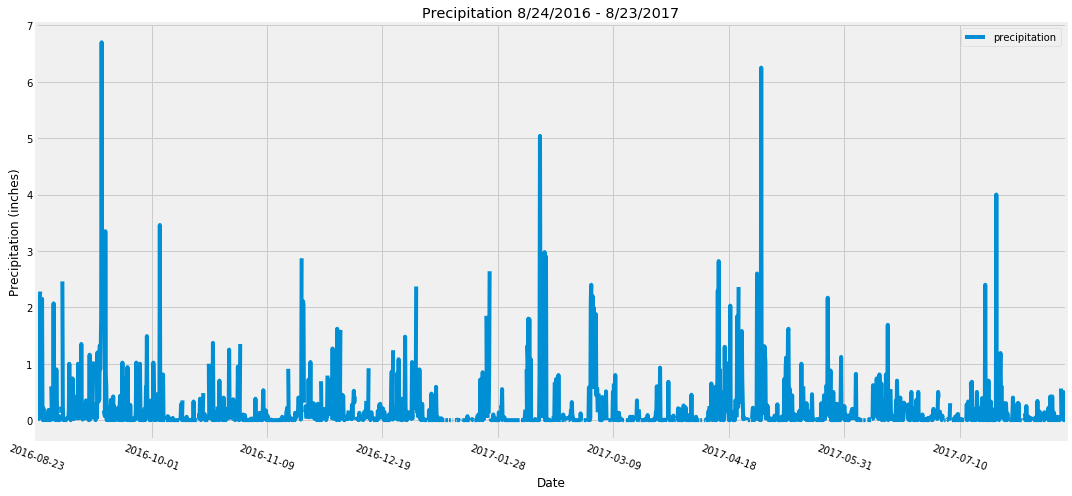

In [18]:
#plot data
fig, ax = plt.subplots(figsize = (15, 7))
# prcp_year_df.plot(x='date',y='prcp', figsize = (18,8), rot = 340)
precip_df.plot(ax = ax, x_compat = True, rot =340)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title("Precipitation 8/24/2016 - 8/23/2017")

#save figure
# plt.savefig("Images/precip.png")

#plot figure
plt.tight_layout()
plt.show()


# x_axis = precip_df['date']
# tick_locations = [value for value in x_axis]
# y_axis = precip_df['prcp']
# plt.bar(x_axis, y_axis, color=["blue"], alpha=1, align="center")


# # Create Ticks for Bar Chart's x_axis
# plt.xticks(tick_locations, x_axis, rotation=85, fontsize=12)

# # Set Labels & Title
# plt.ylabel("Precipitation", fontsize=12)
# plt.xlabel("Date",fontsize=12)
# plt.title("Average Employee Salary by Title",fontsize=12)

# # plt.text(45, 35, "Employee Titles", fontsize=12, alpha=0.75 )

# # Save Figure
# # plt.savefig("..//Advanced-Data-Storage-and-Retrieval/Precipitation Analysis.png")

# # Show plot
# plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis
We wish to investigate the actual stations themselves now.

First, we want to know how many stations there are.

In [20]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.id).distinct().count()
# number_of_stations
print(f"The number of stations available: {number_of_stations}")

The number of stations available: 9


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in active_station_counts:
    print(f"Station:{result[0]}  Count:{result[1]}")

Station:USC00519281  Count:2772
Station:USC00519397  Count:2724
Station:USC00513117  Count:2709
Station:USC00519523  Count:2669
Station:USC00516128  Count:2612
Station:USC00514830  Count:2202
Station:USC00511918  Count:1979
Station:USC00517948  Count:1372
Station:USC00518838  Count:511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()                      
print(f"Lowest Temperature:  {round(summary_temps[0][0],2)} Fahrenheit")
print(f"Highest Temperature: {round(summary_temps[0][1],2)} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2],2)} Fahrenheit")

Lowest Temperature:  54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


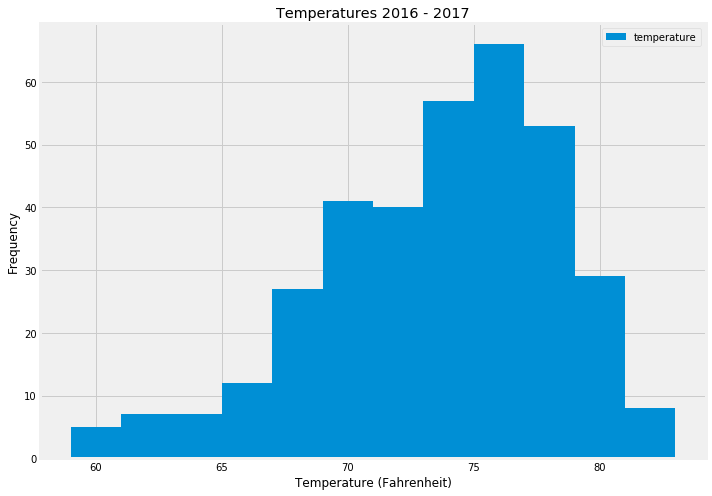

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
filter(func. strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016,8,23)).all()

highest_temps_obs_df = pd.DataFrame(highest_temp_obs, columns = ["date", "temperature"])
highest_temps_obs_df.head()


#plot data
fig, ax = plt.subplots(figsize = (10,7))
highest_temps_obs_df.plot.hist(bins=12, ax = ax)

#set title and labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Temperatures 2016 - 2017")

#save figure
# plt.savefig("Images/precip.png")

#plot figure
plt.tight_layout()
plt.show()


###Step 2 - Climate App

In [ ]:
%load_ext ipyext.writeandexecute
# %%writeandexecute -i myflask myflask.py

#Flask Setup
from flask import Flask
app = Flask(__name__)

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Date, Text
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base() 
from flask import Flask, jsonify
# session=tf.Session() 

#Flask Routes
@app.route("/")
def welcome1():
    """Listing of the available API routes"""
    return(
        f"Available Routes: <br/>"
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )
@app.route("/api/v1.0/precipitation")
def precipitation():
    #Returns a list of precipitation records""""""
    print("Server received request for 'Precipitation' results...")
#Convert the query results to a Dictionary using date as the key and prcp as the value.
    prcp_results = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > '2017-01-01').all()
    
#Return the JSON representation of your dictionary.
    all_prcp = []
    for prcp in prcp_results:
        prcp_dict = {}
        prcp_dict["Date"] = Measurement.date
        prcp_dict["tobs"] = Measurement.tobs
        all_prcp.append(prcp_dict)
        # all_prcp = list(np.ravel(prcp_dict))
#convert list of tuples into normal list 
    # all_prcp = list(np.ravel(results))
    return jsonify(all_prcp)

@app.route("/api/v1.0/stations")
def stations():
    #Returns a list of stations from the dataset in JSON format
    print("Server received request for 'Station' results...")

    station_results = session.query(Stations.station).all()

#convert list of tuples into normal list 
    all_stations = list(np.ravel(station_results))
    return jsonify(all_stations)

# @app.route("/api/v1.0/tobs")
# def tobs():
#     #Returns a list of temperature observations from the last year in JSON format
#     tobs_results = session.query(Measurement.tobs).filter(Measurement.date > '2017-01-01').all()

@app.route("/api/v1.0/tobs")
def tobs():
    results = session.query(Measurement.tobs).\
        filter(Measurement.date >= "2016-08-23").\
        filter(Measurement.date <= "2017-08-23").all()

    results_list = list(np.ravel(results))
    return jsonify(results_list)
#convert list of tuples into normal list 
#     all_tobs = list(np.ravel(tobs_results))
#     return jsonify(all_tobs)

if __name__ == '__main__':
    app.run(debug=False)

'writeandexecute' magic loaded.
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Optional: Other Recommended Analyses
    Temperature Analysis

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps("2017-02-10", "2017-02-25")

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {(trip_temps[0][1],2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')

#save fig
# plt.savefig("Images/tempbar")

#show figure
plt.tight_layout()
plt.show()

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

